In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import os
import tweepy
import covid19

%matplotlib notebook

In [3]:
PATH_TO_TIME_SERIES = r'COVID-19/csse_covid_19_data/csse_covid_19_time_series'
#FILE_NAME_TEMPLATE  = lambda st: f'time_series_19-covid-{st:s}'
FILE_NAME_TEMPLATE = lambda st: f'time_series_covid19_{st:s}_global'
#DATA_TYPES = ['Confirmed', 'Deaths', 'Recovered']
DATA_TYPES = ['confirmed', 'deaths']
EXT = '.csv'
FIG_SIZE = (7, 4.5)

def get_path(type_string):
    file_name = FILE_NAME_TEMPLATE(type_string) + EXT
    p = os.path.join(PATH_TO_TIME_SERIES, file_name)
    return p

def get_doubling_times(dates, data, window=1, limit=100):
    """
    Get rolling doubling times
    """
    day_numbers = (dates.year-2020)*365 + dates.dayofyear
    
    doubling_times = []
    
    # rolling linear fit, window size w
    w = window
    for ii in range(w, (day_numbers.size)):
        start_pos = ii - w
        end_pos = ii + 1
        
        if np.mean(data[start_pos:end_pos]) < limit:
            doubling_times.append(np.nan)
        else:
            days_to_fit = day_numbers[start_pos:end_pos]
            n_to_fit = np.log(data[start_pos:end_pos])
            p = np.polyfit(days_to_fit, n_to_fit, 1)

            doubling_time = 1/p[0]*np.log(2)


            if doubling_time < 0:
                doubling_time = 0

            doubling_times.append(doubling_time)

    np_out = np.array(doubling_times)
    return np_out

def get_days_to_n_cases(doubling_time, cases_now, cases_proj):
    factor_to_go = cases_proj / cases_now    
    doubling_times_to_go = np.log(factor_to_go)/np.log(2)
    
    doubling_times_to_go[doubling_times_to_go<0] = 0
    
    return doubling_times_to_go*doubling_time

def new_fig_ax():
    f = plt.figure(figsize=FIG_SIZE)
    a = f.add_subplot(111)
    return f, a

def new_31sp():
    f = plt.figure(figsize=(6, 15))
    
    ax = ['', '', '']
    ax[0] = f.add_subplot(3, 1, 1)
    ax[1] = f.add_subplot(3, 1, 2)
    ax[2] = f.add_subplot(3, 1, 3)
    return f, ax

In [4]:
# read in new data

dfs = []

for suffix in DATA_TYPES:
    path = get_path(suffix)
    df = pd.read_csv(path)
    dfs.append(df)

confirmed_cases = {}
doubling_times = {}
deaths_ = {}
death_doubling_times = {}
countries = ['United Kingdom', 'Italy', 'Spain', 'Germany', 'France', 'US', 'China', 'Korea, South', 'Japan']

C:\Users\James\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


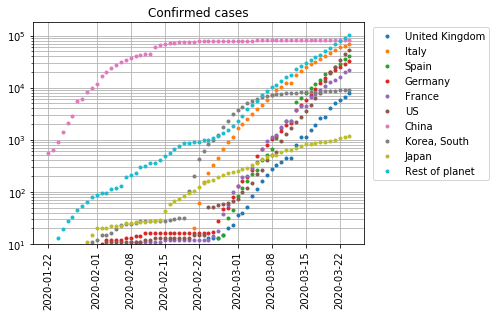

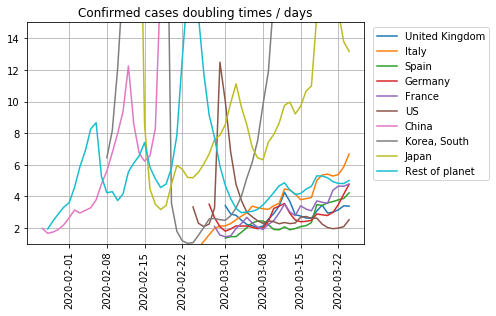

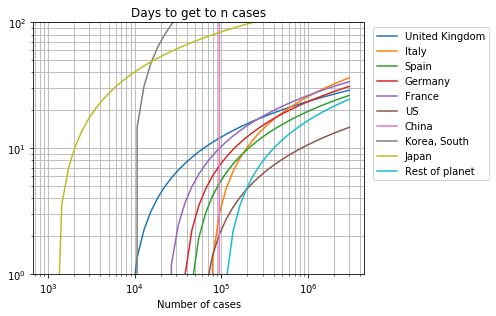

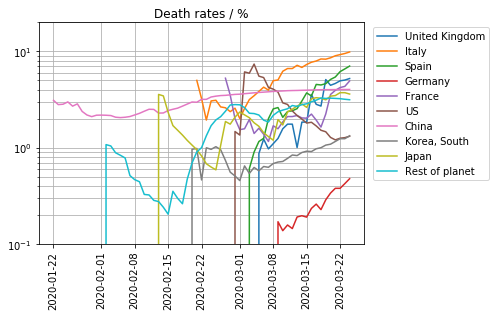

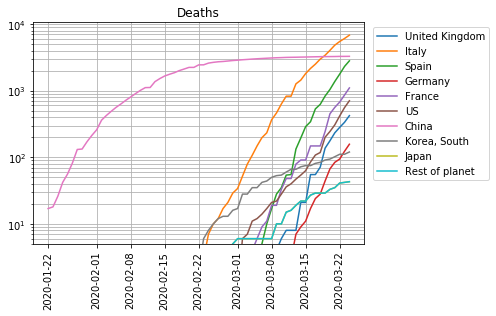

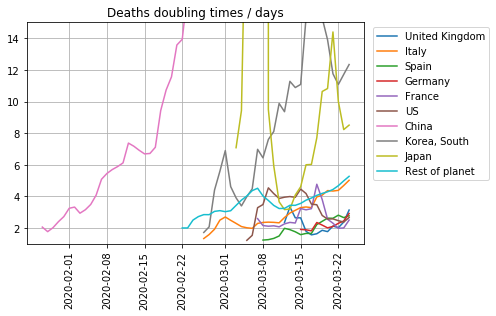

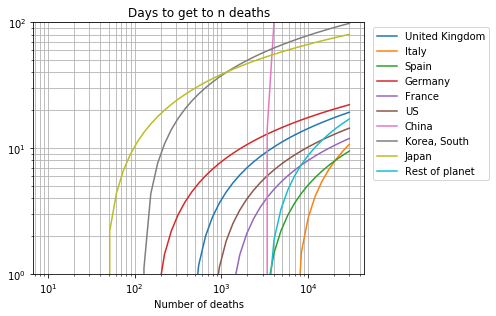

In [5]:
window = 5
n_cases_proj = np.logspace(3, np.log10(3e6), 45);
n_deaths_proj = 0.01 * n_cases_proj

MIN_CASES = 20  # don't calculate the confirmed doubling time if total n deaths less than this
MIN_DEATHS = 5  # don't calculate the death doubling time if total n deaths less than this

f1, ax1 = new_fig_ax()
f2, ax2 = new_fig_ax()
f3, ax3 = new_fig_ax()
f4, ax4 = new_fig_ax()
f5, ax5 = new_fig_ax()
f6, ax6 = new_fig_ax()
f7, ax7 = new_fig_ax()

def get_stats_by_country(data_frame, country_region):
    """
    Fiddle around with the weird province/state information and get out the deaths by country
    """
    
    selected_by_country = data_frame.loc[data_frame['Country/Region'] == country_region]
    
    # find the data where the Province/State is NaN.  In many cases this seems to 
    # indicate the "main" country and not another territory
    no_province = selected_by_country.loc[pd.isna(selected_by_country['Province/State'])]
    
    # if there is just one NaN, then this is probably the data we want
    first_col = 4
    if no_province.shape[0] == 1:
        # the final [0:, ] just returns a series instead of a frame
        data_vs_time = no_province.iloc[:, first_col:].iloc[0, :]
    else:
        # otherwise data has been reported by state, e.g. in the case of China.  Just sum up.
        data_vs_time = selected_by_country.iloc[:, first_col:].sum()

    return data_vs_time



dates = pd.to_datetime(dfs[0].iloc[:, 4:].columns, format='%m/%d/%y')

whole_world_confirmed = dfs[0].iloc[:, 4:].sum()
whole_world_deaths = dfs[1].iloc[:, 4:].sum()

def do_plots(dates, deaths__, confirmed__, country_name):
    d = get_doubling_times(dates, confirmed__, window=window, limit=MIN_CASES)
    
    days_to_n_cases = get_days_to_n_cases(d[-1], confirmed__[-1], n_cases_proj)
    death_rate_pct = 100*deaths__/confirmed__
    death_rate_pct[confirmed__<MIN_CASES] = np.nan
    
    dd = get_doubling_times(dates, deaths__, window=window, limit=MIN_DEATHS)
    
    d_days_to_n_cases = get_days_to_n_cases(dd[-1], deaths__[-1], n_deaths_proj)
    
    c = country_name
    ax1.plot_date(dates, confirmed__, '.', label=c)
        
    ax2.plot_date(dates[window:], d, '-', label=c)

    ax3.plot(n_cases_proj, days_to_n_cases, label=c)
    
    ax4.plot_date(dates, death_rate_pct, '-', label=c)
    
    ax5.plot_date(dates, deaths, '-', label=c)
    
    ax6.plot_date(dates[window:], dd, '-', label=c)
    
    ax7.plot(n_deaths_proj, d_days_to_n_cases, label=c)

for c in countries:
    confirmed = get_stats_by_country(dfs[0], c)
    deaths = get_stats_by_country(dfs[1], c)

    confirmed_cases[c] = confirmed
    deaths_[c] = deaths

    do_plots(dates, deaths, confirmed, c)
    
rest_of_world_confirmed = whole_world_confirmed - pd.DataFrame(confirmed_cases).transpose().sum()
rest_of_world_deaths = whole_world_deaths - pd.DataFrame(deaths_).transpose().sum()

do_plots(dates, rest_of_world_deaths, rest_of_world_confirmed, 'Rest of planet')


ax1.legend(bbox_to_anchor=(1.01, 1))
ax1.set_yscale('log')
ax1.set_ylim(10, )
ax1.set_title('Confirmed cases')
plt.sca(ax1)
ax1.grid(which='both', axis='both')
plt.xticks(rotation=90)
f1.tight_layout()

ax2.legend(bbox_to_anchor=(1.01, 1))
ax2.set_ylim(0, 15)
ax2.set_title('Confirmed cases doubling times / days')
plt.sca(ax2)
#ax2.set_yscale('log')
ax2.set_ylim(1, 15)
ax2.grid(which='both', axis='both')
plt.xticks(rotation=90)
f2.tight_layout()

ax3.legend(bbox_to_anchor=(1.01, 1))
ax3.set_title('Days to get to n cases')
ax3.set_xlabel('Number of cases')
ax3.set_xscale('log')
ax3.set_ylim(1, 100)
ax3.set_yscale('log')
ax3.grid(which='both', axis='both')
f3.tight_layout()

ax4.legend(bbox_to_anchor=(1.01, 1))
ax4.set_title('Death rates / %')
ax4.set_ylim(.1, 20)
ax4.set_yscale('log')
ax4.grid(which='both', axis='both')
plt.sca(ax4)
plt.xticks(rotation=90)
f4.tight_layout()

ax5.legend(bbox_to_anchor=(1.01, 1))
ax5.set_yscale('log')
ax5.set_ylim(MIN_DEATHS, )
ax5.set_title('Deaths')
ax5.grid(which='both', axis='both')
plt.sca(ax5)
plt.xticks(rotation=90)
f5.tight_layout()

ax6.legend(bbox_to_anchor=(1.01, 1))
ax6.set_ylim(0, 15)
ax6.set_title('Deaths doubling times / days')
plt.sca(ax6)
#ax2.set_yscale('log')
ax6.set_ylim(1, 15)
ax6.grid(which='both', axis='both')
plt.xticks(rotation=90)
f6.tight_layout()

ax7.legend(bbox_to_anchor=(1.01, 1))
ax7.set_title('Days to get to n deaths')
ax7.set_xlabel('Number of deaths')
ax7.set_xscale('log')
ax7.set_ylim(1, 100)
ax7.set_yscale('log')
ax7.grid(which='both', axis='both')
f7.tight_layout()

f1.savefig('confirmed.png')
f2.savefig('confirmed_doubling_times.png')
f3.savefig('confirmed_days_to_n.png')
f4.savefig('death_rate.png')
f5.savefig('deaths.png')
f6.savefig('deaths_doubling_times.png')
f7.savefig('deaths_days_to_n.png')

In [472]:
with open('twitterdevkeys.txt', 'r') as f:
    txt = f.readlines()

elements = [a.split(',') for a in txt]
keys = {}
for a in elements:
    keys[a[0]] = a[1].rstrip()

In [473]:
auth = tweepy.OAuthHandler(keys['API key'], keys['API key secret'])
auth.set_access_token(keys['Access token'], keys['Access token secret'])

api = tweepy.API(auth)

try:
    api.verify_credentials()
    print("Authentication OK")
except:
    print("Error during authentication")

Authentication OK


In [474]:
def to_ordinal(cardinal):
    suffices = ["th", "st", "nd", "rd"]

    if cardinal % 10 in [1, 2, 3] and cardinal not in [11, 12, 13]:
        return suffices[cardinal % 10]
    else:
        return suffices[0]

def get_time_str(time):
    string = f"{time.hour}:{time.minute} on {time.day}{to_ordinal(time.day):s} {time.strftime('%b %Y')}"
    return string

def thank(s):
    ack_str = '. Data from @JHUSystems'
    return s + ack_str

def tweet_pic_with_thanks(fname, msg, time_now, reply_id=None):
    time_str = get_time_str(time_now)
    message_with_time = msg + f' at {time_str}'
    full_message = thank(message_with_time)
    
    if reply_id is None:
        t = api.update_with_media(fname, full_message)
    else:
        t = api.update_with_media(fname, '@a_good_brew' + full_message, reply_id)
    return t


time_now = datetime.datetime.now()
time_str = get_time_str(time_now)
user = '@a_good_brew' + ' '

#t0 = api.update_status(thank(f'Plots of #COVID19 deaths at {time_str}'))

#r1 = api.update_with_media('deaths.png', user + 'Total numbers of deaths', t0.id)
#r2 = api.update_with_media('deaths_doubling_times.png', user + 'Doubling rates', t0.id)
#r3 = api.update_with_media('deaths_days_to_n.png', user + 'Death projections', t0.id)

#t1 = tweet_pic_with_thanks('confirmed_days_to_n.png', '#COVID19 case number predictions', time_now)

t1 = tweet_pic_with_thanks('deaths.png', '#COVID19 death stats', time_now)
t2 = tweet_pic_with_thanks('deaths_doubling_times.png', '#COVID19 death doubling times', time_now)
t3 = tweet_pic_with_thanks('deaths_days_to_n.png', '#COVID19 death predictions', time_now)
t4 = tweet_pic_with_thanks('confirmed_days_to_n.png', '#COVID19 case number predictions', time_now)

In [543]:
rest_of_world_confirmed

1/22/20         3
1/23/20         7
1/24/20        13
1/25/20        19
1/26/20        28
            ...  
3/20/20     58325
3/21/20     67454
3/22/20     77836
3/23/20     88488
3/24/20    100689
Length: 63, dtype: int64

In [6]:
dfs[0].sort_values(dfs[0].columns[-1], ascending=False).head(15)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20
137,NaN,Italy,43.0000,12.0000,0,0,0,0,0,0,...,24747,27980,31506,35713,41035,47021,53578,59138,63927,69176
62,Hubei,China,30.9756,112.2707,444,444,549,761,1058,1423,...,67794,67798,67799,67800,67800,67800,67800,67800,67800,67801
225,NaN,US,37.0902,-95.7129,1,1,2,2,5,5,...,3499,4632,6421,7783,13677,19100,25489,33276,43847,53740
201,NaN,Spain,40.0000,-4.0000,0,0,0,0,0,0,...,7798,9942,11748,13910,17963,20410,25374,28768,35136,39885
120,NaN,Germany,51.0000,9.0000,0,0,0,0,0,1,...,5795,7272,9257,12327,15320,19848,22213,24873,29056,32986
133,NaN,Iran,32.0000,53.0000,0,0,0,0,0,0,...,13938,14991,16169,17361,18407,19644,20610,21638,23049,24811
116,NaN,France,46.2276,2.2137,0,0,2,3,3,3,...,4499,6633,7652,9043,10871,12612,14282,16018,19856,22304
206,NaN,Switzerland,46.8182,8.2275,0,0,0,0,0,0,...,2200,2200,2700,3028,4075,5294,6575,7474,8795,9877
143,NaN,"Korea, South",36.0000,128.0000,1,1,2,2,3,4,...,8162,8236,8320,8413,8565,8652,8799,8961,8961,9037
223,NaN,United Kingdom,55.3781,-3.4360,0,0,0,0,0,0,...,1140,1543,1950,2626,2689,3983,5018,5683,6650,8077
